In [1]:
from pathlib import Path
import sys

helper_utils = Path.cwd() / "utils"
sys.path.append(str(helper_utils))

import utils 
from PIL import Image
import pandas as pd 


Faculty of Science and Engineering 🔬
The University of Manchester 
Invoking utils version: 0.4.1


In [3]:
data_path = Path.cwd() / "data"
dataset_path = utils.download_dataset(url=utils.DATA_URLS['spot welding'],
                                   dest_path=data_path,
                                   extract=True)

Extracting rwh8kjzdch-2.zip: 100%|██████████| 1486/1486 [00:00<00:00, 1546.21it/s]


In [4]:
images = list(Path.rglob(dataset_path, "RGB*B.jpg"))
prop_file = list(Path.rglob(dataset_path, "*.csv"))

In [5]:
prop_df = pd.read_csv(prop_file[0])

In [6]:
prop_df

,Sample ID,Pressure (PSI),Welding Time (ms),Angle (Deg),Force (N),Current (A),Thickness A (mm),Thickness B (mm),Material,PullTest (N),NuggetDiameter (mm),Category,Comments
0,1,35,200,0,0.00,1315.41,0.922,0.920,AISI 1010 carbon steel,2127.7,2.63,Bad,DOE
1,1,35,200,0,3.41,1337.45,0.922,0.920,AISI 1010 carbon steel,2127.7,2.63,Bad,DOE
2,1,35,200,0,6.82,1081.47,0.922,0.920,AISI 1010 carbon steel,2127.7,2.63,Bad,DOE
3,2,35,1500,0,0.00,1819.13,0.920,0.925,AISI 1010 carbon steel,5346.4,3.34,Good,DOE
4,2,35,1500,0,3.41,2016.44,0.920,0.925,AISI 1010 carbon steel,5346.4,3.34,Good,DOE
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4181,495,60,1200,0,97.38,3681.96,0.631,0.621,AISI 1010 carbon steel,3100.0,3.56,Good,NaN
4182,495,60,1200,0,97.52,3466.37,0.631,0.621,AISI 1010 carbon steel,3100.0,3.56,Good,NaN
4183,495,60,1200,0,97.64,3559.40,0.631,0.621,AISI 1010 carbon steel,3100.0,3.56,Good,NaN
4184,495,60,1200,0,97.77,4254.52,0.631,0.621,AISI 1010 carbon steel,3100.0,3.56,Good,NaN


In [7]:
len(prop_df['Sample ID'].unique())

495

In [8]:
# grab only one row of each unique sample id
prop_df = prop_df.drop_duplicates(subset=['Sample ID'])

In [9]:
y = pd.Categorical(prop_df['Category']).codes
# check the number of unique samples
len(set(y))

3

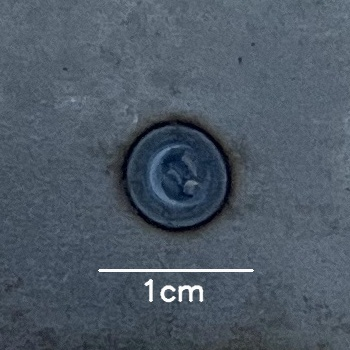

In [10]:
img = Image.open(images[0])
img

In [11]:
img.size

(350, 350)

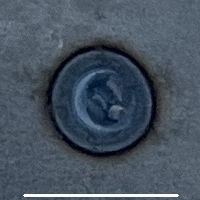

In [12]:
img_ctr_x = img.size[0] // 2
img_ctr_y = img.size[1] // 2

img.crop((img_ctr_x - 100, img_ctr_y - 100, img_ctr_x + 100, img_ctr_y + 100))

In [13]:
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
from torchvision import transforms
import torch

In [14]:
train_x = images[:int(len(images) * 0.8)]
train_y = y[:int(len(images) * 0.8)]
test_x = images[int(len(images) * 0.8):]
test_y = y[int(len(images) * 0.8):]

In [15]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [16]:
crop_transform = transforms.Compose([
    transforms.CenterCrop((200, 200)),
    transforms.ToTensor(),
])
train_dataset = CustomDataset(train_x, train_y, transform=crop_transform)

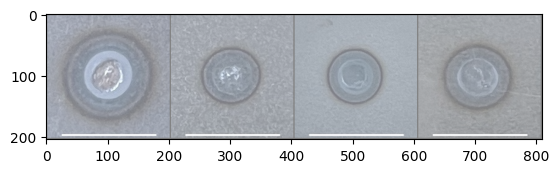

In [17]:
# visualize the first image in the dataset
import matplotlib.pyplot as plt
import torchvision
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))

In [18]:
images[0].max(), images[0].min()

(tensor(1.), tensor(0.))

In [19]:
class simpleCNN(torch.nn.Module):
    def __init__(self):
        super(simpleCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = torch.nn.Linear(32 * 50 * 50, 32)
        self.fc2 = torch.nn.Linear(32, 32)
        self.fc3 = torch.nn.Linear(32, len(set(y)))

    def forward(self, x):
        x = self.pool(torch.nn.functional.relu(self.conv1(x)))
        x = self.pool(torch.nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 32 * 50 * 50)
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x
import torch.optim as optim
import torch.nn as nn
import time


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = simpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 10

train_dataset = CustomDataset(train_x, train_y, transform=crop_transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = CustomDataset(test_x, test_y, transform=crop_transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

def train_model(model, criterion, optimizer, train_loader, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).type(torch.long)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

    return model

start_time = time.time()
model = train_model(model, criterion, optimizer, train_loader, num_epochs=num_epochs)
end_time = time.time()

Epoch [1/10], Loss: 5.0132
Epoch [2/10], Loss: 0.5778
Epoch [3/10], Loss: 0.4856
Epoch [4/10], Loss: 0.4228
Epoch [5/10], Loss: 0.3855
Epoch [6/10], Loss: 0.4069
Epoch [7/10], Loss: 0.3690
Epoch [8/10], Loss: 0.4496
Epoch [9/10], Loss: 0.4193
Epoch [10/10], Loss: 0.4347


In [20]:
def accuracy(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).type(torch.long)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

accuracy(model, test_loader)

0.898989898989899